<font size=6>**Fitting Univariate Distributions**</font>
___

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('bmh')

# Import data

In [2]:
returns = pd.read_excel('returns.xlsx').set_index('Date')
returns.tail()

,Bond,Commo,SP500,CorpBondLT,CorpBondST
Date,,,,,
2024-12-23,-0.005495,-0.010693,0.005988,-0.004768,-0.000640
2024-12-24,0.003285,0.005169,0.011115,0.004893,0.001029
2024-12-26,0.000291,-0.002338,0.000067,0.000798,0.000642
2024-12-27,-0.007128,0.003749,-0.010527,-0.007179,-0.000514
2024-12-30,0.006740,0.011204,-0.011412,0.005490,0.001798


# Fitting a distribution to the S&P 500 returns

In [3]:
r = returns['SP500']

## Obtain the Maximum Likelihood estimators

Use [`scipy.stats.rv_continuous.fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html) where `rv_continuous` = `norm` and `rv_continuous` = `t` for the Normal and t distributions.

In [5]:
mu, sigma = stats.norm.fit(r)
nu, loc, scale = stats.t.fit(r)
print(fr"Normal : mu={mu:.5f}, sigma={sigma:.5f}")
print(fr"Student: df={nu:.2f}, loc={loc:.5f}, scale={scale:.5f}")

Normal : mu=0.00062, sigma=0.01323
Student: df=3.00, loc=0.00103, scale=0.00798


Print the the different estimators of the mean

In [7]:
print(f"Sample mean                = {r.mean():.5%}")
print(f"Mean of the fitted Normal  = {mu:.5%}")
print(f"Mean of the fitted Student = {loc:.5%}")

Sample mean                = 0.06210%
Mean of the fitted Normal  = 0.06210%
Mean of the fitted Student = 0.10275%


Print the the different estimators of the standard deviation

In [8]:
print(f"Sample volatility                        = {r.std(ddof=1):.5%}")
print(f"Standard deviation of the fitted Normal  = {sigma:.5%}")
print(f"Standard deviation of the fitted Student = {scale*np.sqrt(nu/(nu-2)):.5%}")

Sample volatility                        = 1.32318%
Standard deviation of the fitted Normal  = 1.32265%
Standard deviation of the fitted Student = 1.38210%


Create an histogram of the returns and overlay the pdf of the Normal and $t$ distributions with the MLE of the parameters.  
The `hist()` function needs the arg `density=True` to be normalized and share the y axis with a pdf.

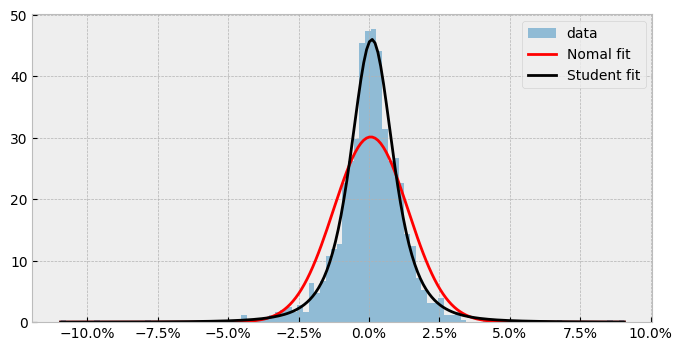

In [9]:
x = np.linspace(r.min(), r.max(), 200)
pdf_n = stats.norm.pdf(x, loc=mu, scale=sigma)
pdf_t = stats.t.pdf(x, df=nu, loc=loc, scale=scale)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist( r    , density=True, bins=100, alpha=0.5, label="data")
ax.plot( x    , pdf_n     , color='red', label="Nomal fit")
ax.plot( x    , pdf_t     , color='black', label="Student fit")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend();

Zoom on the *shoulder*

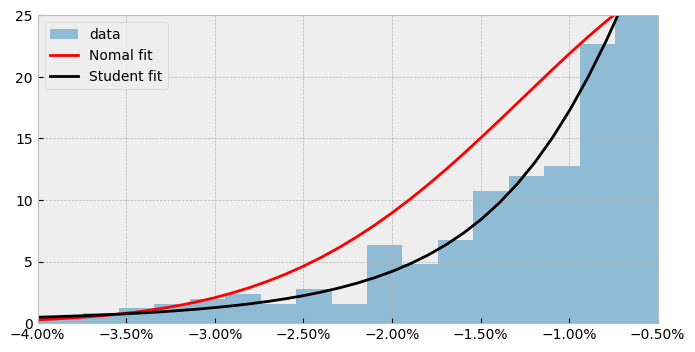

In [10]:
ax.set_xlim((-0.04, -0.005))
ax.set_ylim((0, 25))
fig

Zoom on the *left tail*

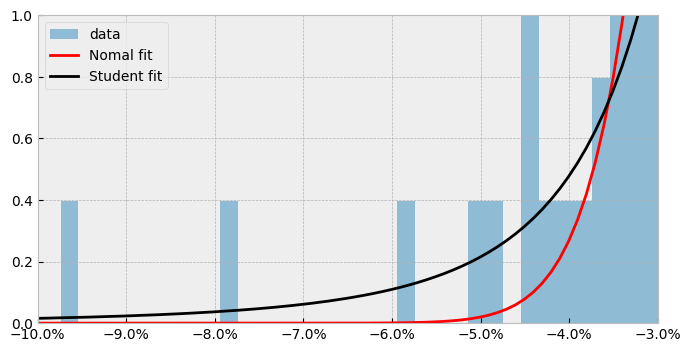

In [11]:
ax.set_xlim((-0.1, -0.03))
ax.set_ylim((0, 1))
fig

## Comparing the models using Information Criteria (IC)

### Functions that compute AIC and BIC

In [14]:
def AIC(nll, nparams):
    """
    Compute the Akaike Information Criterion
    Parameters:
      nll : negative maximized loglikelihood of the sample
      nparams : number of free parameters in the model
    """
    aic = 2 * nll+ 2 * nparams
    return aic

def BIC(nll, nparams, n):
    """
    Compute the Bayesian Information Criterion
    Parameters:
      nll : negative maximized loglikelihood of the sample
      nparams : number of free parameters in the model
      n : sample size
    """
    bic = 2 * nll + np.log(n) * nparams
    return bic

### Compute and display the AIC and BIC values for the two models

Compute the negative log likelihood using the [`scipy.stats.rv_continuous.nnlf(params, x)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.nnlf.html) method. `params`is a list or array_like.

In [15]:
nll_norm = stats.norm.nnlf((mu, sigma), r)
nll_t = stats.t.nnlf((nu, loc, scale), r)

print("Negative log likelihood for")
print(f"- Normal distribution        : {nll_norm:.2f}")
print(f"- Student's t distribution   : {nll_t:.2f}")

Negative log likelihood for
- Normal distribution        : -3650.68
- Student's t distribution   : -3839.73


In [16]:
# Store the additional parameters
n = len(r)
nparams_norm = 2
nparams_t = 3

# Compute the IC values and store in a list
norm_IC_values = [nll_norm, AIC(nll_norm, nparams_norm), BIC(nll_norm, nparams_norm, n)]
t_IC_values = [nll_t, AIC(nll_t, nparams_t), BIC(nll_t, nparams_t, n)]

# Display the IC values using a DataFrame
IC = pd.DataFrame({'norm': norm_IC_values, 't': t_IC_values},
                  index=['nll', 'AIC', 'BIC'])
IC.round(1)

,norm,t
nll,-3650.7,-3839.7
AIC,-7297.4,-7673.5
BIC,-7287.1,-7658.0


# Fit Normal and Student's $t$ distributions to returns

In [17]:
def compute_MLE(data):
    n_days = 260
    n_days_sqrt = math.sqrt(n_days)
    sample_size = data.shape[0]
    nparams_norm = 2
    nparams_t = 3
    estimators = []
    IC = []
    moments = []

    for colummn in data:
        r = data[colummn]
        # ML estimators
        mu, sigma = stats.norm.fit(r)
        nu, loc, scale = stats.t.fit(r)
        estimators.append([f"{mu:.3%}", f"{sigma:.3%}", f"{nu:.1f}", f"{loc:.3%}", f"{scale:.3%}"])
        # information criteria
        nll_norm = stats.norm.nnlf([mu, sigma], r)
        nll_t = stats.t.nnlf([nu, loc, scale], r)
        IC.append([f"{nll_norm:.2f}",
                   f"{nll_t:.2f}",
                   f"{AIC(nll_norm, nparams_norm):.2f}",
                   f"{AIC(nll_t, nparams_t):.2f}",
                   f"{BIC(nll_norm, nparams_norm, sample_size):.2f}",
                   f"{BIC(nll_t, nparams_t, sample_size):.2f}"
                   ])
        # moments of t distribution are not always defined
        if nu > 1:
            mean = f"{n_days*loc:.2%}"
        else:
            mean = "undefined"
        if nu > 2:
            stdev = f"{n_days_sqrt*scale*math.sqrt(nu/(nu-2)):.2%}"
        elif nu > 1:
            stdev = "infinite"
        else:
            stdev = "undefined"
        moments.append([f"{n_days*mu:.2%}", f"{n_days_sqrt*sigma:.2%}", mean, stdev])
    
    # create DataFrames
    index = pd.MultiIndex.from_arrays(
        [["Normal", "Normal", "Student", "Student", "Student"], ["mean", "std dev", "df", "location", "scale"]],
        names=["distribution", "parameter"]
         )
    df_MLE = pd.DataFrame(np.array(estimators).T, columns=data.columns, index=index)
    index = pd.MultiIndex.from_product(
        [["nll", "AIC", "BIC"], ["Normal", "Student"]],
        names=["criteria", "distribution"]
         )
    df_IC = pd.DataFrame(np.array(IC).T, columns=data.columns, index=index)
    index = pd.MultiIndex.from_product(
        [["Normal", "Student"], ["mean", "std dev"]],
        names=["distribution", "moments"]
         )
    df_moments = pd.DataFrame(np.array(moments).T, columns=data.columns, index=index)

    # display DataFrames
    print("ML Estimators")
    display(df_MLE)
    print("Information Criteria")
    display(df_IC)
    print("Moments from distributions with MLE parameters")
    display(df_moments)


compute_MLE(returns)

ML Estimators


Bond   Commo   SP500 CorpBondLT CorpBondST
distribution parameter                                               
Normal       mean       -0.009%  0.035%  0.062%    -0.003%     0.008%
             std dev     0.921%  1.568%  1.323%     1.023%     0.278%
Student      df             5.3     4.1     3.0        3.7        2.0
             location    0.005%  0.103%  0.103%     0.012%     0.008%
             scale       0.714%  1.112%  0.798%     0.654%     0.103%

Information Criteria


Bond     Commo     SP500 CorpBondLT CorpBondST
criteria distribution                                                    
nll      Normal        -4105.85  -3436.73  -3650.68   -3972.79   -5607.62
         Student       -4179.68  -3547.75  -3839.73   -4178.31   -6184.87
AIC      Normal        -8207.70  -6869.45  -7297.36   -7941.58  -11211.23
         Student       -8353.36  -7089.51  -7673.45   -8350.61  -12363.74
BIC      Normal        -8197.43  -6859.18  -7287.09   -7931.31  -11200.96
         Student       -8337.95  -7074.10  -7658.04   -8335.21  -12348.34

Moments from distributions with MLE parameters


Bond   Commo   SP500 CorpBondLT CorpBondST
distribution moments                                              
Normal       mean     -2.29%   9.14%  16.15%     -0.70%      2.05%
             std dev  14.84%  25.29%  21.33%     16.50%      4.49%
Student      mean      1.39%  26.83%  26.71%      3.07%      2.11%
             std dev  14.57%  25.02%  22.29%     15.52%   infinite